In [8]:
'''
Tasks:
1)Extract parameters in the NeuroDyn model from electrophysiology experiments, following the methodology of Hodgkin and Huxley.
2)Study consistency/discrepancies between extracted and simulated parameters in software. 
3)Demonstrate a systematic means to arrive at parameters to produce HH dynamics in the NeuroDyn hardware.

Omowuyi Olajide
'''


'\nTasks:\n1)Extract parameters in the NeuroDyn model from electrophysiology experiments, following the methodology of Hodgkin and Huxley.\n2)Study consistency/discrepancies between extracted and simulated parameters in software. \n3)Demonstrate a systematic means to arrive at parameters to produce HH dynamics in the NeuroDyn hardware.\n\nOmowuyi Olajide\n'

In [ ]:
Environment Setup

In [4]:
import matplotlib.pyplot as plt
from cb_models import HHModel, NeuroDynModel

# **Ignore overflow warnings**
import numpy as np
np.seterr(all="ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
Hodgkin-Huxley model

In [5]:
hh_neuron = HHModel()

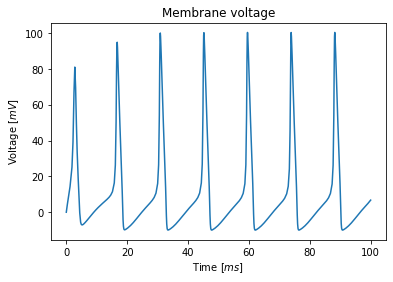

In [3]:
def Iapp(t):
    I0 = 10 # applied current in uA
    return I0

T = 100 # length of the simulation in ms
trange = (0, T)

x0 = [0,0,0,0] # initial conditions [V0, m0, h0, n0]

sol = hh_neuron.simulate(trange, x0, Iapp)

plt.figure()
plt.xlabel("Time [$ms$]")
plt.ylabel("Voltage [$mV$]")
plt.title("Membrane voltage")
plt.plot(sol.t, sol.y[0])
plt.show()

In [ ]:
Voltage and time scaling

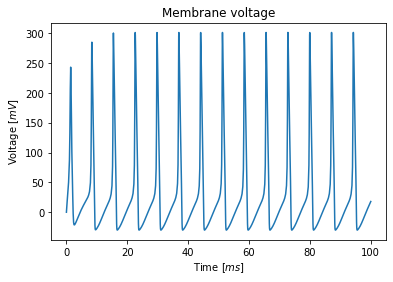

In [6]:
hh_neuron_scaled = HHModel(scl_v = 3, scl_t = 2)

def Iapp(t):
    I0 = 10 # applied current in uA
    return I0

T = 100 # length of the simulation in ms
trange = (0, T)

x0 = [0,0,0,0] # initial conditions [V0, m0, h0, n0]

sol = hh_neuron_scaled.simulate(trange, x0, Iapp)

plt.figure()
plt.xlabel("Time [$ms$]")
plt.ylabel("Voltage [$mV$]")
plt.title("Membrane voltage")
plt.plot(sol.t, sol.y[0])
plt.show()

In [ ]:
NeuroDyn model

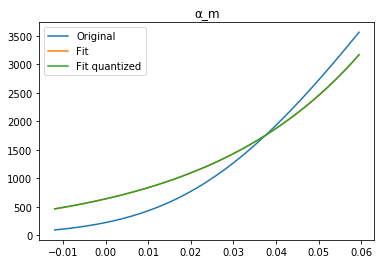

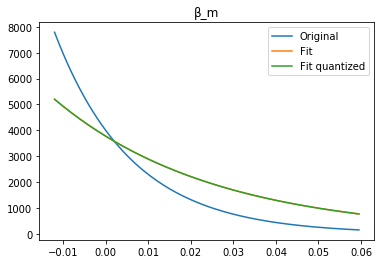

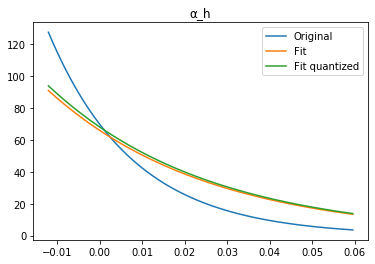

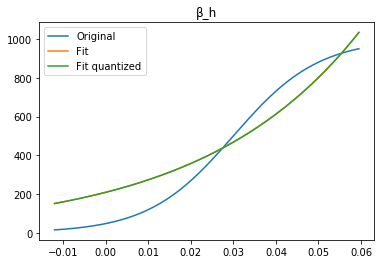

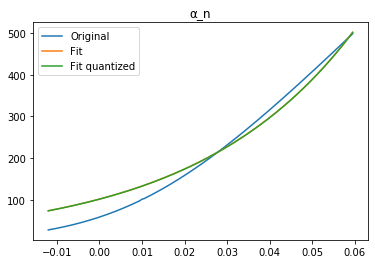

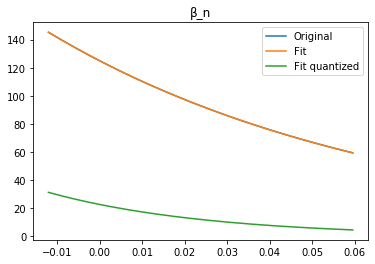

In [10]:
nd_neuron = NeuroDynModel()
from fitting_utilities import FitND
hh_neuron = HHModel(SI_units = True)

fit_obj = FitND(hh_neuron)
weights = fit_obj.fitHH(plot_alpha_beta=True) # weights stores the sigmoid coefficients

In [ ]:
Changing the voltage scaling

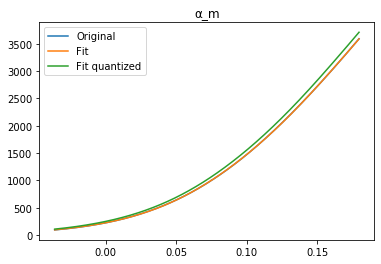

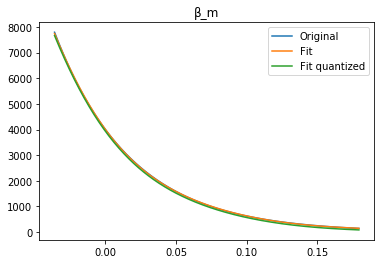

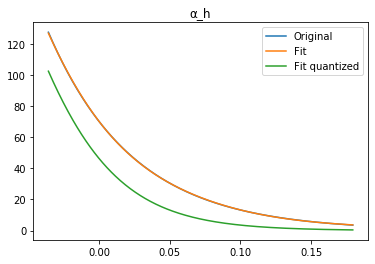

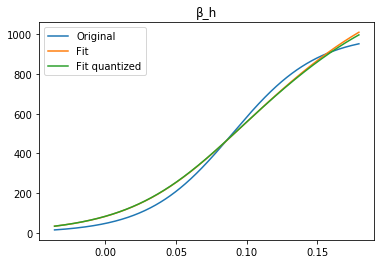

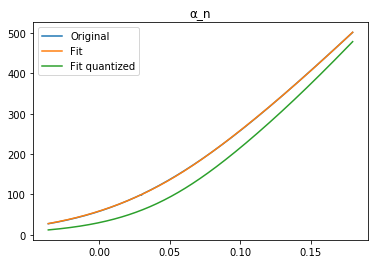

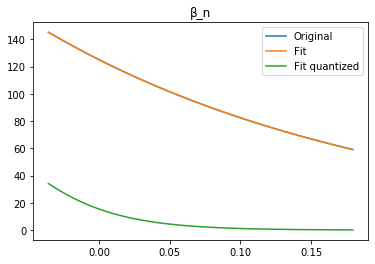

In [11]:
scl_v = 3 # voltage scaling

hh_neuron = HHModel(scl_v = scl_v, SI_units = True)

fit_obj = FitND(hh_neuron)

weights = fit_obj.fitHH(plot_alpha_beta = True)

In [ ]:
Getting the parameters

In [12]:
g0 = [120e-3,36e-3,0.3e-3] # maximal conductances
E0 = [120e-3,-12e-3,10.6e-3] # reversal potentials
dIb = fit_obj.get_digital_Ib(weights)
dg = fit_obj.get_digital_g(g0)
dE = fit_obj.get_digital_E(E0)

I_master = fit_obj.I_master
I_voltage = fit_obj.I_voltage

# Manually increase coefficients if too low after fitting
dIb[2][1] = dIb[2][1]*15

scl_t = fit_obj.get_scl_t()
print("The time scaling scl_t is", scl_t) 

#%% Print the parameter values
print('\nImaster = ', I_master)
print('Ivoltage = ', I_voltage)

print('\nDigital values for maximal conductances:')
print('[gna, gk, gl] = ', dg, '\n')

print('Digital values for reversal potentials:')
print('[Ena, Ek, El] = ', dE, '\n')

print('Digital values for gating variable kinetics:')
print('alpha_m = ', dIb[0][0])
print('beta_m = ', dIb[0][1], '\n')
print('alpha_h = ', dIb[1][0])
print('beta_h = ', dIb[1][1], '\n')
print('alpha_n = ', dIb[2][0])
print('beta_n = ', dIb[2][1], '\n')

The time scaling scl_t is 11.206993689903845

Imaster =  2e-07
Ivoltage =  1.5e-07

Digital values for maximal conductances:
[gna, gk, gl] =  [1023.  307.    3.] 

Digital values for reversal potentials:
[Ena, Ek, El] =  [ 829. -829. -545.] 

Digital values for gating variable kinetics:
alpha_m =  [  0.   1.  11.  23.   0.   0. 870.]
beta_m =  [190.   4.   6.   0.   0.   0.   0.] 

alpha_h =  [3. 0. 0. 0. 0. 0. 0.]
beta_h =  [0. 0. 6. 3. 0. 0. 0.] 

alpha_n =  [0. 0. 2. 2. 3. 0. 0.]
beta_n =  [15.  0.  0.  0.  0.  0.  0.] 



In [ ]:
Simulating the fitted model

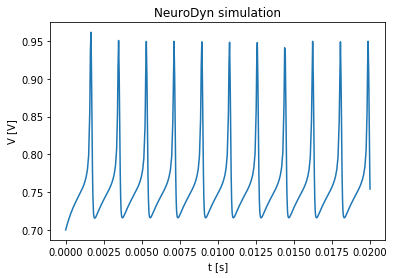

In [13]:
I0 = 0e-6 # current in the original Hodgkin-Huxley model
Iapp = lambda t : fit_obj.convert_I(I0) # scale the current based on scl_t, scl_v and C_HH/C_ND

V_ref = 0.9

ND = NeuroDynModel(dg, dE, dIb, V_ref, I_voltage, I_master)

T = 0.02
trange = (0, T)

sol = ND.simulate(trange,[0.7,0,0,0],Iapp)

plt.figure()
plt.xlabel('t [s]')
plt.ylabel('V [V]')
plt.title('NeuroDyn simulation')
plt.plot(sol.t, sol.y[0])
plt.show()

In [ ]:
Compare this to the scaled Hodgkin-Huxley model

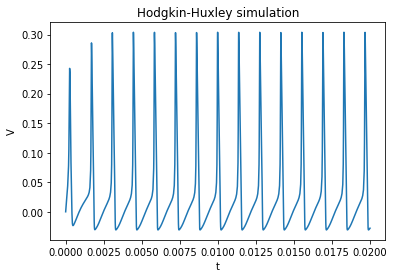

In [14]:
hh_neuron = HHModel(scl_v = 3, scl_t = scl_t, SI_units = True)

I0 = 8e-6
Iapp = lambda t: I0

T = 0.02
trange = (0, T)

sol = hh_neuron.simulate(trange,[0,0,0,0],Iapp)

plt.figure()
plt.xlabel('t')
plt.ylabel('V')
plt.title('Hodgkin-Huxley simulation')
plt.plot(sol.t, sol.y[0])
plt.show()

In [ ]:
Passing analog values to NeuroDyn

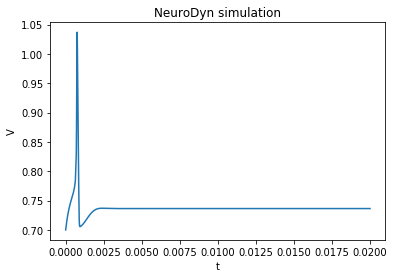

In [15]:
Ib = fit_obj.get_analog_Ib(weights)
g = fit_obj.get_analog_g(g0)
E = fit_obj.get_analog_E(E0)

ND_analog = NeuroDynModel(g, E, Ib, V_ref, I_voltage, I_master, digital_values = False)

I0 = 0e-6 # current in the original Hodgkin-Huxley model
Iapp = lambda t : fit_obj.convert_I(I0) # scale the current based on scl_t and C_HH/C_ND

T = 0.02
trange = (0, T)

sol = ND_analog.simulate(trange,[0.7,0,0,0],Iapp)

plt.figure()
plt.xlabel('t')
plt.ylabel('V')
plt.title('NeuroDyn simulation')
plt.plot(sol.t, sol.y[0])
plt.show()

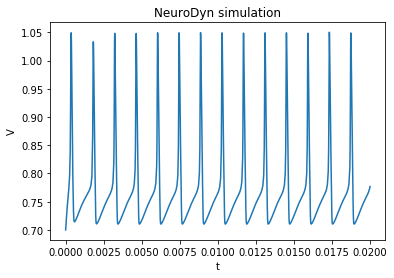

In [16]:
g[1] = 0.6*g[1] # decrease potassium conductance

ND_analog = NeuroDynModel(g, E, Ib, V_ref, I_voltage, I_master, digital_values = False)

I0 = 7e-6 # current in the original Hodgkin-Huxley model
Iapp = lambda t : fit_obj.convert_I(I0) # scale the current based on scl_t and C_HH/C_ND

T = 0.02
trange = (0, T)

sol = ND_analog.simulate(trange,[0.7,0,0,0],Iapp)

plt.figure()
plt.xlabel('t')
plt.ylabel('V')
plt.title('NeuroDyn simulation')
plt.plot(sol.t, sol.y[0])
plt.show()

In [ ]:
Modelling variability - Perturb function

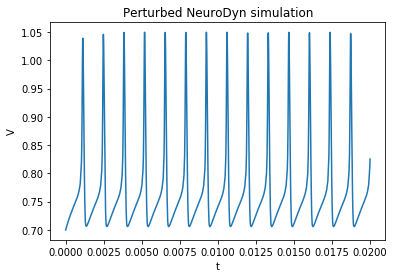

In [17]:
I0 = 0e-6
Iapp = lambda t : fit_obj.convert_I(I0)

ND.perturb() # leaving out the keyword argument sets default sigma = 0.15

sol = ND.simulate(trange,[0.7,0,0,0],Iapp)

plt.figure()
plt.xlabel('t')
plt.ylabel('V')
plt.title('Perturbed NeuroDyn simulation')
plt.plot(sol.t, sol.y[0])
plt.show()

In [18]:
print("The current value of applied current is ", I0)
print("The current values for the maximal conductances are", dg)

The current value of applied current is  0.0
The current values for the maximal conductances are [1023.  307.    3.]


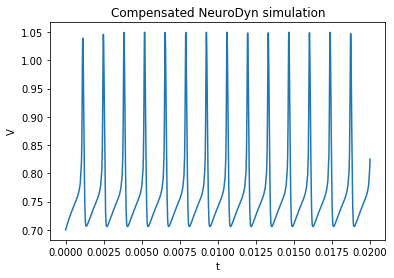

In [19]:
# First try changing the applied current
I0 = 0e-6
Iapp = lambda t : fit_obj.convert_I(I0)

# If changing applied current didn't help, try adjusting the maximal conductances
# dg = [1023, 307, 3]
dg_comp = np.array([1023, 307, 3])
ND.update_dg(dg_comp)

sol = ND.simulate(trange,[0.7,0,0,0],Iapp)

plt.figure()
plt.xlabel('t')
plt.ylabel('V')
plt.title('Compensated NeuroDyn simulation')
plt.plot(sol.t, sol.y[0])
plt.show()